In [ ]:
# install the package if it is not already available
!pip install git+https://github.com/aurelio-amerio/MixtureEM.git

# if you are running this code from the cloned repository, you can use the following command instead
# import sys
# sys.path.append('../src/MixtureEM')

In [1]:
import numpy as np
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # only display errors and warnings
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # uncomment to run on CPU

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

import matplotlib.pyplot as plt


from MixtureEM import MixtureEM



2024-04-22 21:50:46.007225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class MultivariateNormalDiag(tfd.Distribution):
    def __init__(self, loc, scale_diag):
        self.loc = loc
        self.scale_diag = scale_diag
        self.dim = loc.shape[-1]
        super(MultivariateNormalDiag, self).__init__(
            dtype=tf.float32,
            reparameterization_type=tfd.FULLY_REPARAMETERIZED,
            validate_args=False,
            allow_nan_stats=True,
            parameters=dict(locals()),
        )

    def _log_prob(self, x):
        return tf.reduce_sum(
            tfd.Normal(loc=self.loc, scale=self.scale_diag).log_prob(x), axis=-1
        )

    # the sample function is only needed if you want to sample from the distribution
    def _sample_n(self, n, seed=None):
        return self.loc + self.scale_diag * tf.random.normal(
            shape=(n, self.dim), seed=seed
        )

    def _event_shape(self):
        return tf.TensorShape([self.dim])



In [3]:
mu1 = tf.constant([1.0, 1.0], dtype=tf.float32)
sigma_diag1 = tf.constant([1.0, 1.0], dtype=tf.float32)
dist1 = MultivariateNormalDiag(
    loc=mu1, scale_diag=sigma_diag1
)

mu2 = tf.constant([3.0, 3.0], dtype=tf.float32)
sigma_diag2 = tf.constant([1.0, 1.0], dtype=tf.float32)

dist2 = MultivariateNormalDiag(
    loc=mu2, scale_diag=sigma_diag2
)

p = [0.4, 0.6]

dist = tfd.Mixture(
    cat=tfd.Categorical(probs=p),
    components=[dist1, dist2]
)

2024-04-22 21:50:50.071135: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:

data = dist.sample(1000)


/lhome/ific/a/aamerio/miniconda3/envs/dmhalos/lib/python3.10/site-packages/tensorflow_probability/python/distributions/mixture.py:333: UserWarning: Falling back to stateful sampling for `components[0]` multivariate_normal_diag of type `<class '__main__.MultivariateNormalDiag'>`. Please update to use `tf.random.stateless_*` RNGs. This fallback may be removed after 20-Aug-2020. (Expected int for argument 'seed2' not <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1389841752,   71041085], dtype=int32)>.)
  warnings.warn(msg.format(c, self.components[c].name,
/lhome/ific/a/aamerio/miniconda3/envs/dmhalos/lib/python3.10/site-packages/tensorflow_probability/python/distributions/mixture.py:333: UserWarning: Falling back to stateful sampling for `components[1]` multivariate_normal_diag of type `<class '__main__.MultivariateNormalDiag'>`. Please update to use `tf.random.stateless_*` RNGs. This fallback may be removed after 20-Aug-2020. (Expected int for argument 'seed2' not <tf.Tensor: shape=

In [5]:
mu1_var = tf.Variable([0.0, 0.0], dtype=tf.float32, name="mu1")
sigma_diag1_var = tf.Variable([2.0, 2.0], dtype=tf.float32, name="sigma1")

mu2_var = tf.Variable([6.0, 6.0], dtype=tf.float32, name="mu2")
sigma_diag2_var = tf.Variable([2.0, 2.0], dtype=tf.float32, name="sigma2")

model1 = MultivariateNormalDiag(loc=mu1_var, scale_diag=sigma_diag1_var)
model2 = MultivariateNormalDiag(loc=mu2_var, scale_diag=sigma_diag2_var)

model = MixtureEM(initial_probs=[0.49, 0.51], components=[model1, model2])

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [7]:
model.fit(data, optimizer, algo="EM", opt_steps=100, likelihood_opt_steps=500, lr=1e-3)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:43<00:00,  2.31it/s, Log Likelihood: -3370.0764]


# plot results

In [8]:
for var in model.dist_variables:
    print(var.name, " ",var.numpy())

print("probs: ", model.probs_parameter.numpy())

mu1:0   [0.95289326 1.0433952 ]
sigma1:0   [1.0791512 0.989011 ]
mu2:0   [2.9872968 3.0402553]
sigma2:0   [1.0573192 0.9980212]
probs:  [0.4029966 0.5970036]


In [12]:
posterior_probs = model.posterior_probs(data)

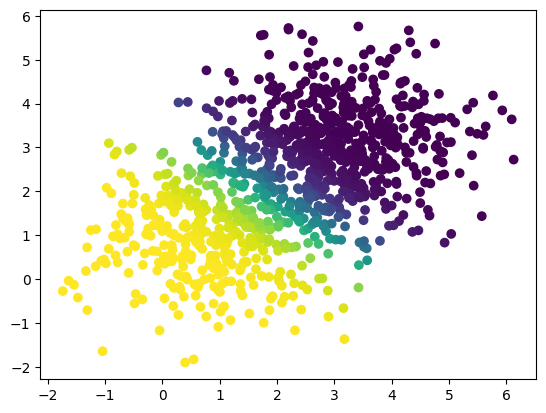

In [13]:
plt.scatter(data[:, 0], data[:, 1], c=posterior_probs[:,0])
plt.show()

In [14]:
predictions = model.predict(data)

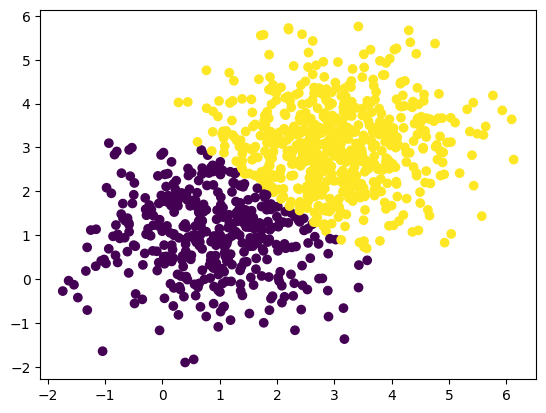

In [15]:
plt.scatter(data[:, 0], data[:, 1], c=predictions)
plt.show()